<a href="https://colab.research.google.com/github/MaksimReznicenko/Maksim_Reznichenko/blob/main/practice_clustering_02_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Популярные методы кластеризации
# K-means


## Данные

Сегодня мы будем работать с [Human Activity Recognition Using Smartphones Dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Данные содержат информацию, снятую по показаниям смартфонов Samsung.

Целевой переменной является вид активности, которую выполняет человек в данный момент.

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import zipfile

# === Загрузка X из архива на Google Drive ===
file_id_X = '1PC0Z_6gK5kEPM4KgpZAR4adZPTKOTXs7'
url_X = f'https://drive.google.com/uc?export=download&id={file_id_X}'

response_X = requests.get(url_X)
zip_file = zipfile.ZipFile(io.BytesIO(response_X.content))
csv_filename = zip_file.namelist()[0]  # предполагаем, что внутри только один .csv
X = pd.read_csv(zip_file.open(csv_filename)).values  # сразу получаем numpy-массив

# === Загрузка y из .txt на Google Drive ===
file_id_y = '16p_MwFgtJsUTdfTQnO53R-Yu35fSQXtf'
url_y = f'https://drive.google.com/uc?export=download&id={file_id_y}'

response_y = requests.get(url_y)
y = np.loadtxt(io.BytesIO(response_y.content)).astype(int)

# Проверка
print(X.shape)
print(y.shape)
print(X[:5])
print(y[:5])

(7352, 561)
(7352,)
[[ 0.2885845  -0.02029417 -0.13290514 ... -0.8412468   0.17994061
  -0.05862692]
 [ 0.27841884 -0.01641057 -0.12352019 ... -0.8447876   0.1802889
  -0.05431672]
 [ 0.27965307 -0.01946716 -0.11346169 ... -0.84893346  0.18063731
  -0.04911782]
 [ 0.27917394 -0.02620065 -0.12328257 ... -0.8486494   0.18193476
  -0.04766318]
 [ 0.27662876 -0.01656965 -0.11536185 ... -0.8478652   0.18515116
  -0.04389225]]
[5 5 5 5 5]


In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

[Эти лейблы соотвествуют следующим активностям:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

## Basic EDA

Попробуем как-то визуализировать данные.

Данные содержат 561 компоненту. Посмотрим, что будет, если визуализировать первые две из них.

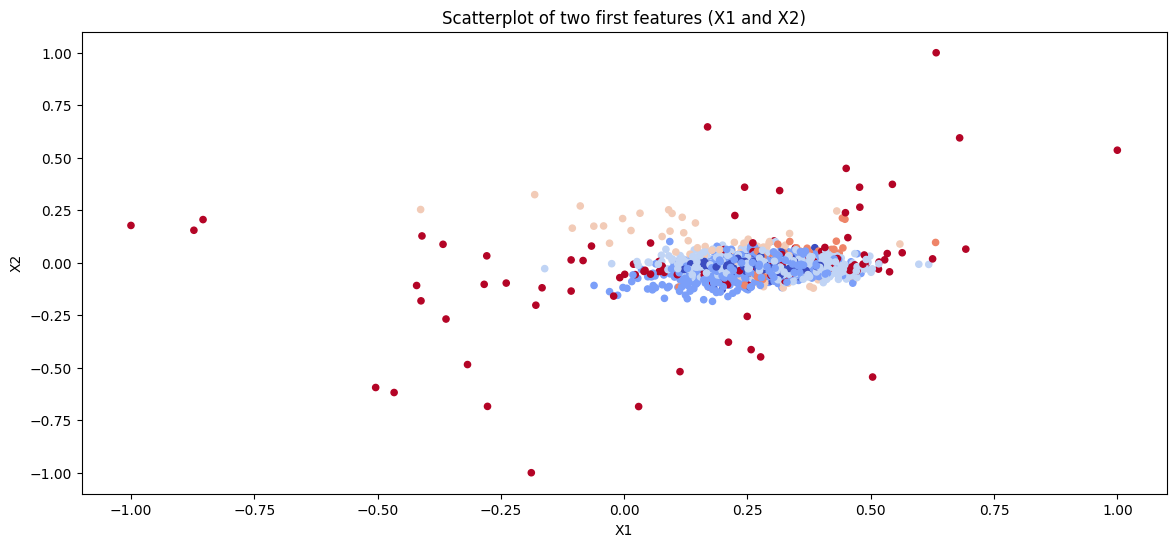

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 6))

plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='coolwarm')

plt.title('Scatterplot of two first features (X1 and X2)')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

Ничего непонятно. Давайте попробуем воспользоваться PCA!

**Recap question:** кратко опишите, как устроен PCA.

Не забудем в начале нормализовать данные.

**Recap question:**  почему для PCA так важна нормализация?


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

In [ ]:
X_pca.shape

(7352, 561)

### Визуализация PCA

Давайте сравним, как изменилась картина после применения PCA.

Еще раз вспомним, как выглядели исходные данные.



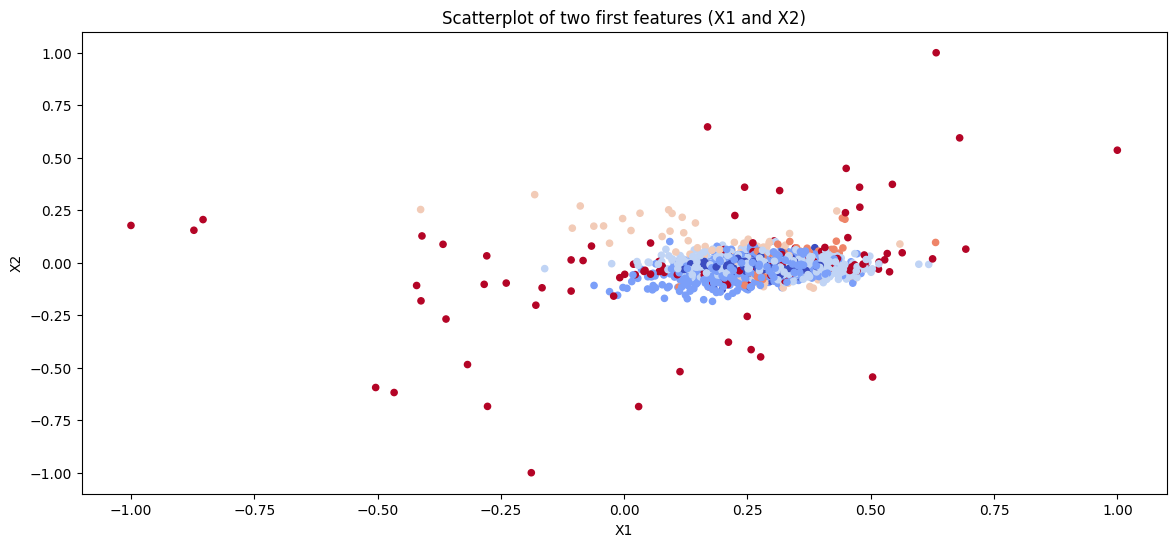

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='coolwarm')

plt.title('Scatterplot of two first features (X1 and X2)')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

А теперь визуализируем, как они выглядят после PCA.

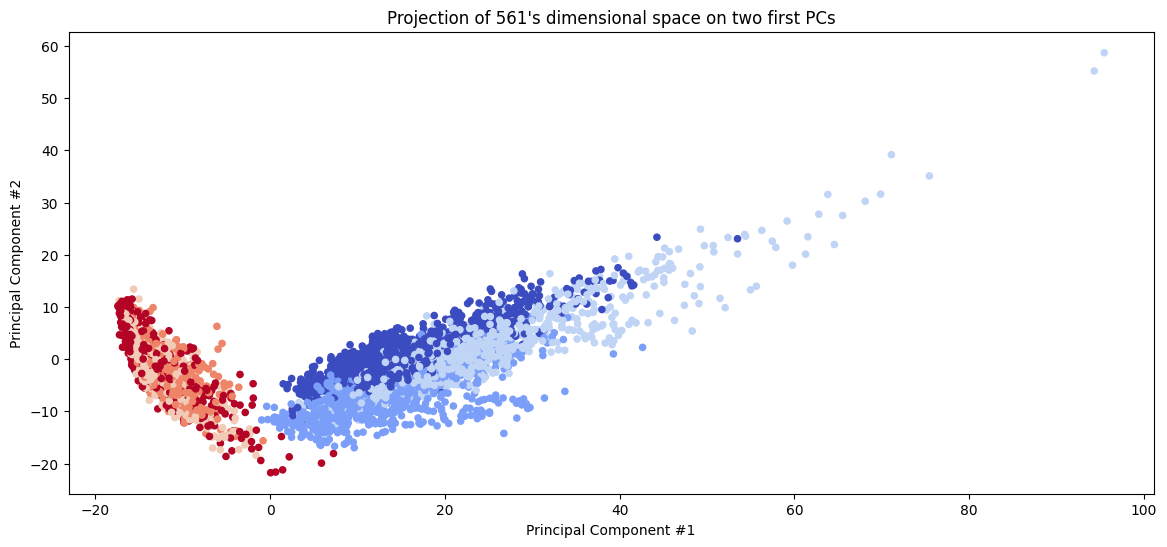

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='coolwarm')

plt.title('Projection of 561\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
d

np.int64(63)

Кажется, отличный результат. Давайте для решения задачи кластеризации перейдем к главным компонентам. Для удобства визуализации возьмем первык 2 (главные) компоненты.

In [ ]:
X_63_dim = X_pca[:, :63]

#idx = (X_63_dim[:,0] < 50) & (X_63_dim[:,1] < 15)

X_63_dim = X_63_dim #[idx,:]

In [ ]:
X_two_dim = X_pca[:, :2]

idx = (X_two_dim[:,0] < 50) & (X_two_dim[:,1] < 15)

X_two_dim = X_two_dim #[idx,:]

## Кластеризация

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи.

Формално, **кластеризация** — задача группировки множества объектов на подмножества (кластеры) таким образом, чтобы объекты из одного кластера были более похожи друг на друга, чем на объекты из других кластеров по какому-либо критерию.

Задача кластеризации относится к классу задач обучения без учителя.

### k-Means

Алгоритм **K-means** (он же К-средних), наверное, самый популярный и простой алгоритм кластеризации и очень легко представляется в виде простого псевдокода:


    1) Выбрать количество кластеров k, которое нам кажется оптимальным для наших данных.

    2) Высыпать случайным образом в пространство наших данных k точек (центроидов).

    3) Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.

    4) Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.

    5) Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

В качестве дефолтного baseline обучим самый простой kmeans с кластеризацией на 2 кластера.

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_63_dim)

KMeans(n_clusters=2)

Посмотрим, как выглядят получившиеся кластера.


In [ ]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

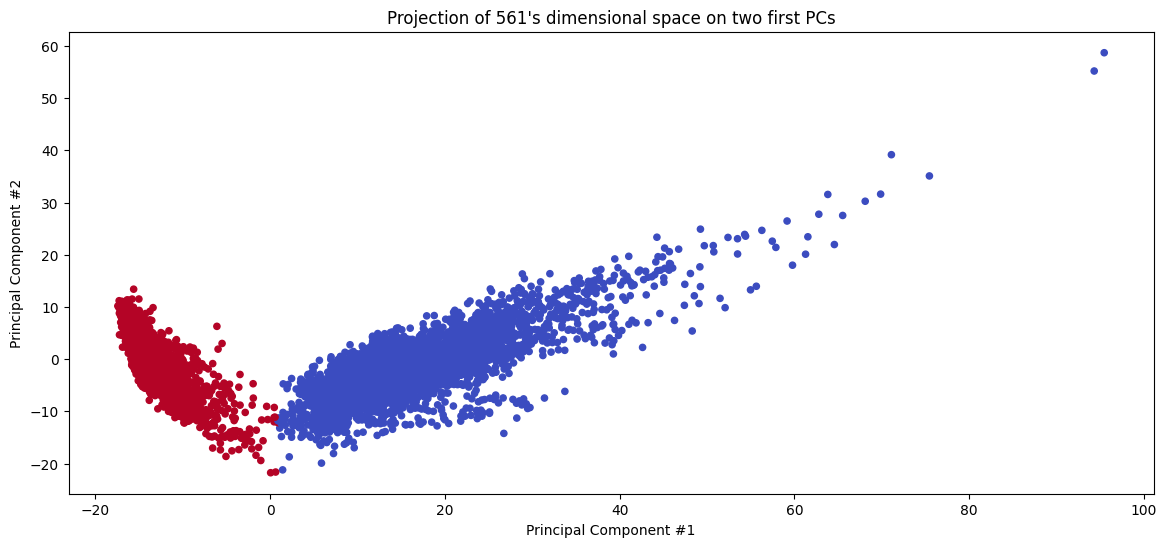

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X_two_dim[:,0], X_two_dim[:,1], c=kmeans.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 561\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

# DBSCAN

[Наглядная визуализация](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) DBSCAN.


<img src="https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg" width=500>

**Алгоритм:**
- 1. Выбираем случайную точку и находим её соседей в заданной
окрестности
- 2. Если соседей меньше критического значения – называем выбросами
- 3. Если нет – объединяем в «плотный» кластер и повторяем поиск соседей
- 4. Если все плотные точки пройдены и помечены как посещенные – выбираем новую не посещенную точку и начинаем сначала

Повторяем, пока все точки не будут посещены


**Преимущества:**
- Density-based (плотностной/вероятностный) метод – умеет в сложные формы кластеров
- Поиск выбросов и аномалий в данных

**Недостатки:**
- Довольно сложный в настройке – очень чувствителен к параметру ”плотности” epsilon

In [ ]:
# Прямая ссылка на скачивание файла с Google Drive (user content)
url = "https://drive.usercontent.google.com/download?id=1b6bK8V-2fKfKQ8z8zqYQbkjRasUaPFiZ&export=download&authuser=0&confirm=t&uuid=09175432-4e29-4265-98b2-03b28c9212c5&at=AO7h07eejM3soJYP_v4aDNZKJhyf:1725021024305"

# Загружаем CSV-файл напрямую
response = requests.get(url)
data = pd.read_csv(io.BytesIO(response.content))

# Выводим форму и первые строки
print(data.shape)
data.head()

(156, 9)


,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


In [ ]:
data.drop('Country or region', axis=1, inplace=True)
data.drop('Overall rank', axis=1, inplace=True)

In [ ]:
data.describe()

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,5.407096,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,1.113120,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.544500,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,5.379500,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,6.184500,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,7.769000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


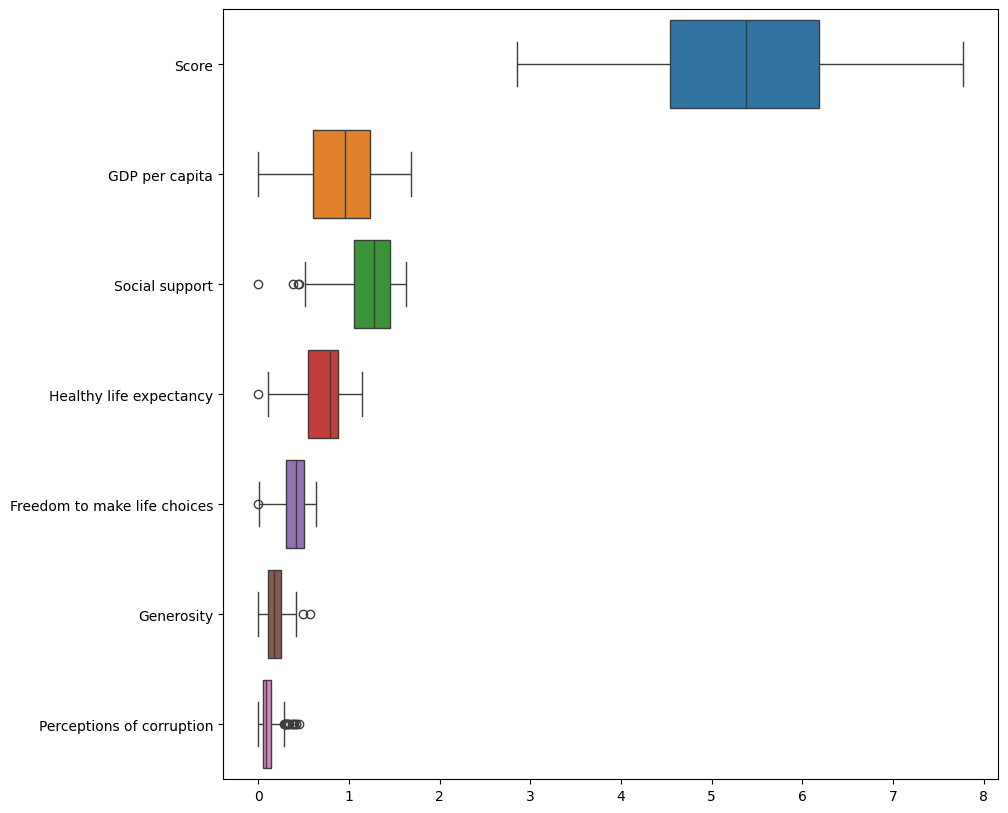

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data, orient='h');

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(X_scaled, columns=data.columns)
data_scaled.head()

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1.000000,0.795724,0.977217,0.864154,0.944532,0.270318,0.867550
1,0.965622,0.821259,0.968596,0.872918,0.938193,0.445230,0.905077
2,0.956265,0.883610,0.974138,0.900964,0.955626,0.478799,0.752759
3,0.944060,0.819477,1.000000,0.899211,0.936609,0.625442,0.260486
4,0.942840,0.828979,0.937192,0.875548,0.882726,0.568905,0.657837


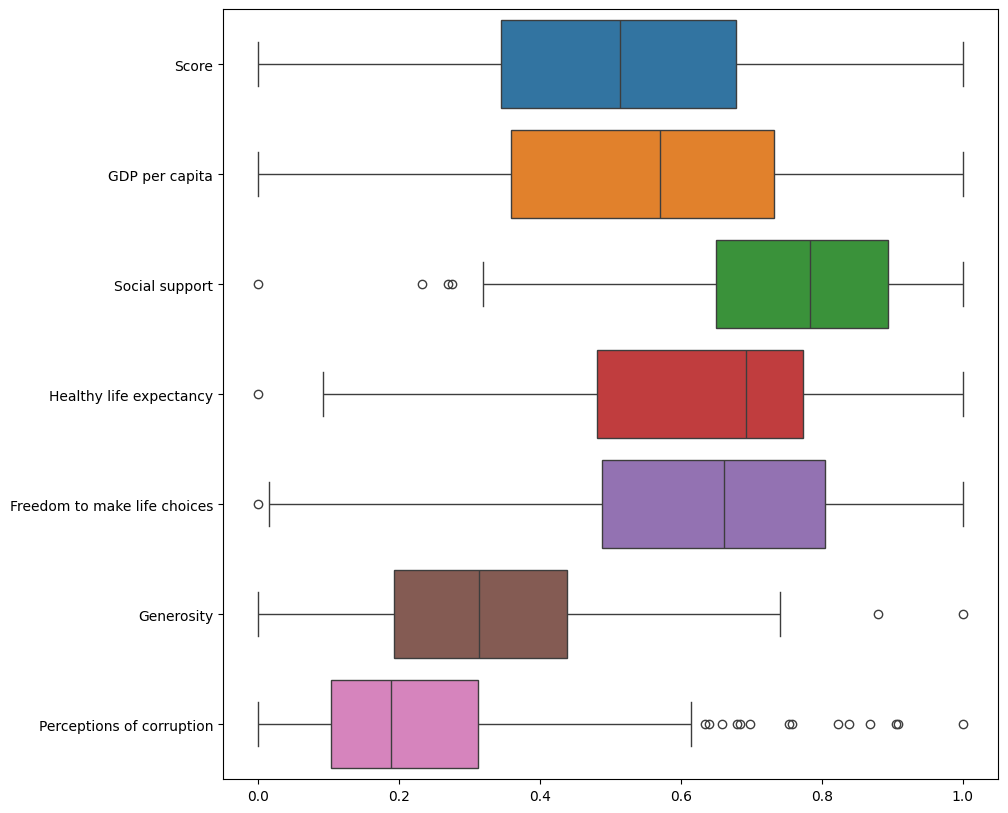

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data_scaled, orient='h');

## Снижение размерности для визуализации

(156, 2)


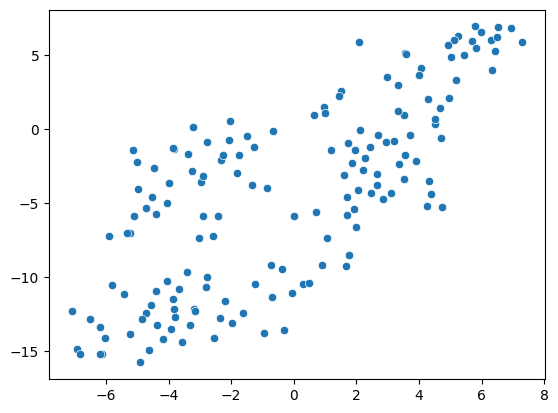

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10)
X_tsne = tsne.fit_transform(X_scaled)
print(X_tsne.shape)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1]);

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.245).fit(X_scaled)
labels = dbscan.labels_

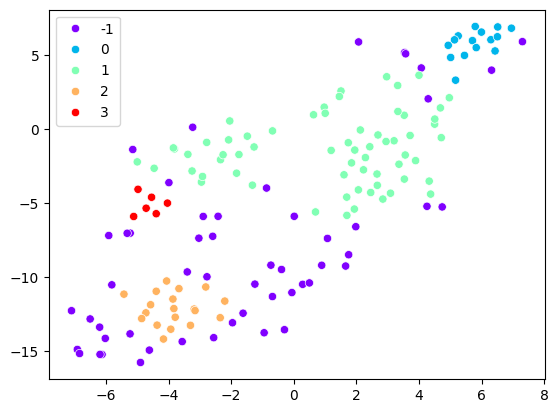

In [ ]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');